### Requirements

In [ ]:
!pip install torch diffusers weasyprint PyMuPDF accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/openai/CLIP.git@a1d071733d7111c9c014f024669f959182114e33

  Cloning https://github.com/openai/CLIP.git (to revision a1d071733d7111c9c014f024669f959182114e33) to /tmp/pip-req-build-ltp8a2jq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ltp8a2jq
  Running command git rev-parse -q --verify 'sha^a1d071733d7111c9c014f024669f959182114e33'
  Running command git fetch -q https://github.com/openai/CLIP.git a1d071733d7111c9c014f024669f959182114e33
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 714.2 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=14087afa828df9672acf8c482c1e85ba609c9e4cba065ab18a8afa5d25fd0dff
  Stored in directory: /root/.cache/pip/wheels/df/64/50/148b28b28a0f816d0e876207653618a4ec90e3a9c0f9c6e2a5
Successfully built clip


In [ ]:
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git

Cloning into 'FastSAM'...
remote: Enumerating objects: 1221, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 1221 (delta 229), reused 205 (delta 196), pack-reused 932
Receiving objects: 100% (1221/1221), 72.46 MiB | 42.26 MiB/s, done.
Resolving deltas: 100% (486/486), done.


In [ ]:
!pip install -r /content/FastSAM/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.7/611.7 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins 

### Imports

In [ ]:
import io
import fitz
import torch
import base64
import numpy as np
from PIL import Image
from io import BytesIO
from weasyprint import HTML
from FastSAM.fastsam import FastSAM, FastSAMPrompt
from diffusers import StableDiffusionImg2ImgPipeline

In [ ]:
class ImageProcessor:
    def __init__(self, device):
        self.device = device
        self.diffusion_model_id = "runwayml/stable-diffusion-v1-5"
        self.pipe = StableDiffusionImg2ImgPipeline.from_pretrained(self.diffusion_model_id).to(device)
        self.pipe.safety_checker = None
        self.fastsam = FastSAM('models/FastSAM-x.pt')

    def process_image(self, init_image, prompt, hex_color):
        everything_results = self.fastsam(init_image, device=self.device, retina_masks=True, imgsz=1024, conf=0.4, iou=0.9)
        prompt_process = FastSAMPrompt(init_image, everything_results, device=self.device)
        ann = prompt_process.text_prompt(text=prompt)

        changed_image = self.change_image_color_with_mask(init_image, ann, hex_color)

        images = self.pipe(prompt=prompt, image=changed_image, strength=0.75, guidance_scale=7.5).images
        return images[0]

    def change_image_color_with_mask(self, image, mask_tensor, hex_color):
        mask = Image.fromarray(mask_tensor.squeeze().astype(np.uint8) * 255)

        color = hex_color.replace("#", "")+'ff'  # Add alpha value
        color = tuple(int(color[i:i+2], 16) for i in (0, 2, 4, 6))

        colored_image = Image.new('RGBA', image.size, color)
        masked_colored_image = Image.composite(colored_image, image, mask)
        return masked_colored_image.convert('RGB')

In [ ]:
class AdCreator:

    def generate_ad(self, logo_image, main_image, hex_color, punchline, button_text):
        pdf = self.generate_pdf(logo_image, main_image, hex_color, punchline, button_text)
        response_image = self.pdf_to_high_res_image_with_crop(pdf)
        return response_image

    def image_to_data_uri(self, image):
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        return f"data:image/png;base64,{img_str}"

    def generate_pdf(self, logo_image, main_image, hex_color, punchline, button_text):
        logo_data_uri = self.image_to_data_uri(logo_image)
        main_image_data_uri = self.image_to_data_uri(main_image)

        html_content = f'''
        <!DOCTYPE html>
        <html>
        <head>
            <style>
                body {{
                    font-family: Arial, sans-serif;
                    text-align: center;
                    margin: 0;
                    padding: 20px;
                }}
                .container {{
                    background-color: #f8eddb;
                    width: auto;
                    height: auto;
                    padding: 20px;
                }}
                .logo {{
                    max-width: 200px;
                    height: auto;
                    margin: 20px auto;
                    display: block;
                }}
                .main-image {{
                    max-width: 500px;
                    height: auto;
                    margin: 20px auto;
                    display: block;
                    border-radius: 20px;
                }}
                .punchline {{
                    color: {hex_color};
                    font-size: 24px;
                    margin: 20px 0;
                }}
                .button {{
                    background-color: {hex_color};
                    border: none;
                    color: white;
                    padding: 15px 32px;
                    text-align: center;
                    text-decoration: none;
                    display: block;
                    font-size: 16px;
                    margin: 20px auto;
                    cursor: pointer;
                    border-radius: 15px;
                    box-sizing: border-box;
                    max-width: 90%;
                    overflow-wrap: break-word;
                    white-space: normal;
                    width: 500px;
                    height: auto;
                }}
            </style>
        </head>
        <body>
            <div class="container">
                <img src="{logo_data_uri}" class="logo">
                <img src="{main_image_data_uri}" class="main-image">
                <div class="punchline">{punchline}</div>
                <div class="button-container">
                    <button class="button">{button_text}</button>
                </div>
            </div>
        </body>
        </html>
        '''
        return HTML(string=html_content).write_pdf()

    def pdf_to_high_res_image_with_crop(self, pdf, dpi=300):
        doc = fitz.open("pdf", pdf)
        if len(doc) == 0:
            raise ValueError("The PDF file has no pages.")

        page = doc.load_page(0)

        pix = page.get_pixmap(matrix=fitz.Matrix(dpi / 72, dpi / 72))
        img_data = pix.tobytes("png")
        img = Image.open(io.BytesIO(img_data))
        img_np = np.array(img)

        rows = np.any(img_np != [255, 255, 255], axis=1)
        cols = np.any(img_np != [255, 255, 255], axis=0)
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]

        cropped_img = img.crop((xmin, ymin, xmax, ymax))

        doc.close()
        return cropped_img

### Image Processor & Ad Creator

In [ ]:
image_processor = ImageProcessor(device='cuda' if torch.cuda.is_available() else 'cpu')
ad_creator = AdCreator()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### Inference

#### Task 1

##### Input

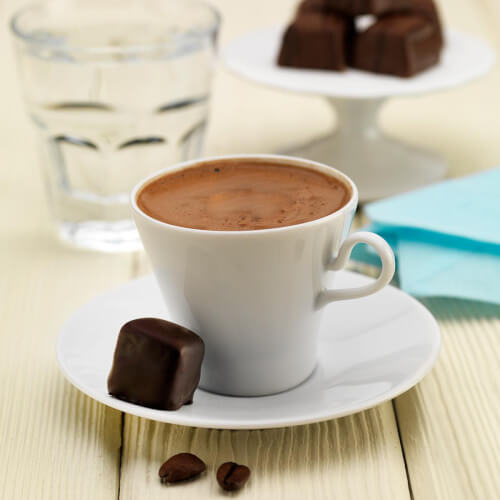

In [ ]:
image_path = "/content/kahve.png"
prompt = "cup of tea"
hex_color = "#0000FF"

image_file = Image.open(image_path).convert("RGB")
image_file

##### Output

In [ ]:
response_image = image_processor.process_image(image_file, prompt, hex_color)


WARNING ⚠️ NMS time limit 0.550s exceeded
0: 1024x1024 28 objects, 181.1ms
Speed: 99.1ms preprocess, 181.1ms inference, 864.3ms postprocess per image at shape (1, 3, 1024, 1024)
100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 136MiB/s]


  0%|          | 0/37 [00:00<?, ?it/s]

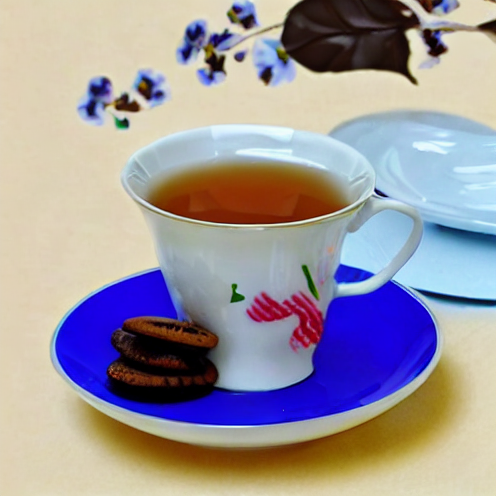

In [ ]:
response_image

#### Task 2

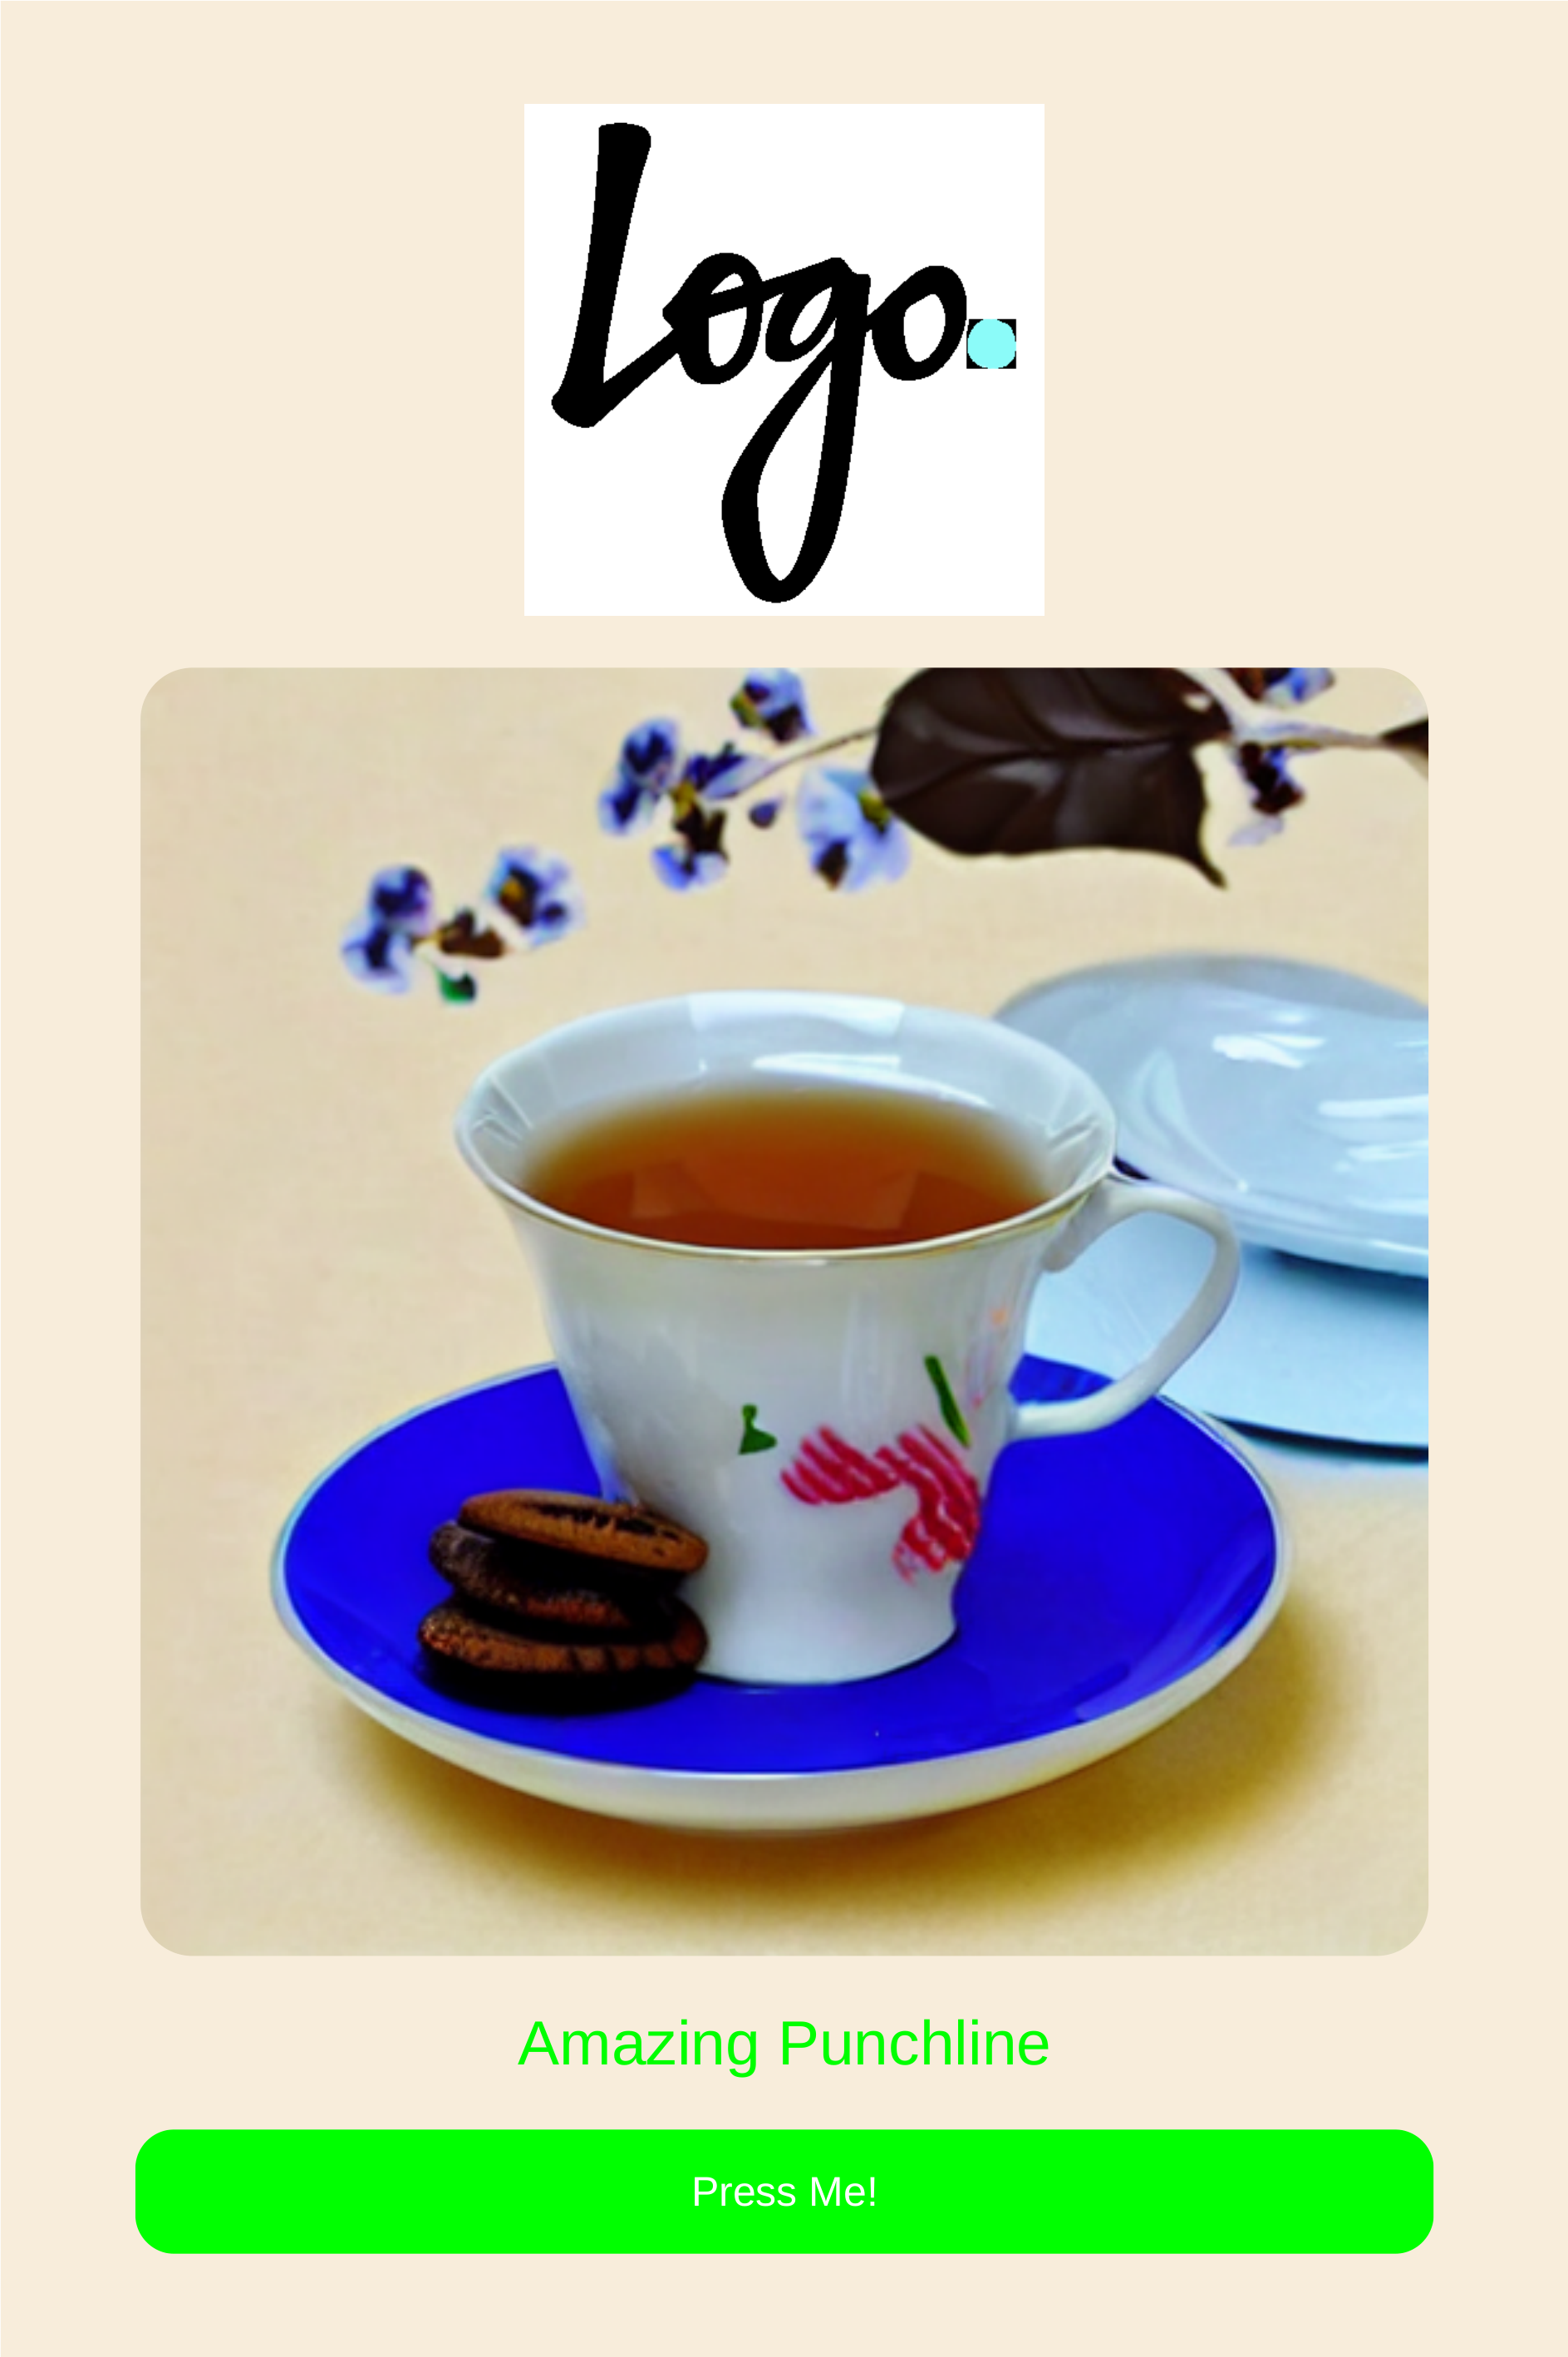

In [ ]:
logo_image = Image.open("/content/logo.png").convert("RGB")
main_image = response_image
hex_color = "#00FF00"
punchline = "Amazing Punchline"
button_text = "Press Me!"

ad_image = ad_creator.generate_ad(logo_image, main_image, hex_color, punchline, button_text)
ad_image